# The Alien Blaster problem

This notebook presents solutions to exercises in Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np

from thinkbayes2 import Hist, Pmf, Cdf, Suite, Beta
import thinkplot

## Part One

In preparation for an alien invasion, the Earth Defense League has been working on new missiles to shoot down space invaders.  Of course, some missile designs are better than others; let's assume that each design has some probability of hitting an alien ship, $x$.

Based on previous tests, the distribution of $x$ in the population of designs is well-modeled by a beta distribution with parameters $\alpha=2$ and $\beta=3$.  What is the average missile's probability of shooting down an alien?

0.4

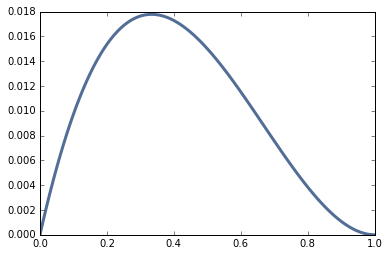

In [2]:
prior = Beta(2, 3)
thinkplot.Pdf(prior.MakePmf())
prior.Mean()

In its first test, the new Alien Blaster 9000 takes 10 shots and hits 2 targets.  Taking into account this data, what is the posterior distribution of $x$ for this missile?  What is the value in the posterior with the highest probability, also known as the MAP?

In [3]:
posterior = Beta(3, 2)
posterior.Update((2, 8))
posterior.MAP()

0.3076923076923077

Now suppose the new ultra-secret Alien Blaster 10K is being tested.  In a press conference, an EDF general reports that the new design has been tested twice, taking two shots during each test.  The results of the test are confidential, so the general won't say how many targets were hit, but they report: "The same number of targets were hit in the two tests, so we have reason to think this new design is consistent." 

Write a class called `AlienBlaster` that inherits from `Suite` and provides a likelihood function that takes this data -- two shots and a tie -- and computes the likelihood of the data for each hypothetical value of $x$.  If you would like a challenge, write a version that works for any number of shots.

In [4]:
from scipy import stats

class AlienBlaster(Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likeliood of data under hypo.
        
        data: number of shots they took
        hypo: probability of a hit, p
        """
        n = data
        x = hypo
        
        # specific version for n=2 shots
        likes = [x**4, (1-x)**4, (2*x*(1-x))**2]

        # general version for any n shots
        likes = [stats.binom.pmf(k, n, x)**2 for k in range(n+1)]
        
        return np.sum(likes)

If we start with a uniform prior, we can see what the likelihood function looks like:

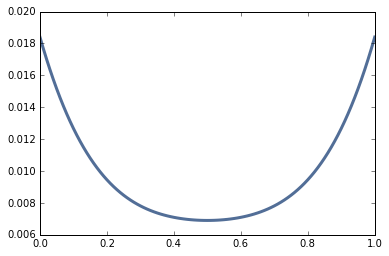

In [5]:
pmf = Beta(1, 1).MakePmf()
blaster = AlienBlaster(pmf)
blaster.Update(2)
thinkplot.Pdf(blaster)

A tie is most likely if they are both terrible shots or both very good.

Is this data good or bad; that is, does it increase or decrease your estimate of $x$ for the Alien Blaster 10K?

Now let's run it with the specified prior and see what happens when we multiply the convex prior and the concave posterior:

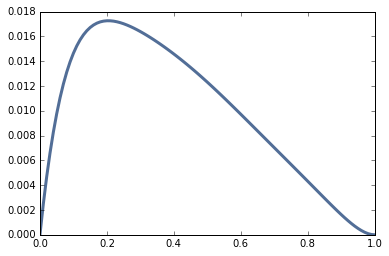

In [6]:
pmf = Beta(2, 3).MakePmf()
blaster = AlienBlaster(pmf)
blaster.Update(2)
thinkplot.Pdf(blaster)

The posterior mean and MAP are lower than in the prior.

In [7]:
prior.Mean(), blaster.Mean()

(0.4, 0.37508201146132331)

In [8]:
prior.MAP(), blaster.MAP()

(0.3333333333333333, 0.2)

So if we learn that the new design is "consistent", it is more likely to be consistently bad (in this case).

## Part Two

Suppose we
have we have a stockpile of 3 Alien Blaster 9000s and 7 Alien
Blaster 10Ks.  After extensive testing, we have concluded that
the AB9000 hits the target 30% of the time, precisely, and the
AB10K hits the target 40% of the time.

If I grab a random weapon from the stockpile and shoot at 10 targets,
what is the probability of hitting exactly 3?  Again, you can write a
number, mathematical expression, or Python code.

In [9]:
k = 3
n = 10
x1 = 0.3
x2 = 0.4

0.3 * stats.binom.pmf(k, n, x1) + 0.7 * stats.binom.pmf(k, n, x2)

0.23054197320000014

The answer is a value drawn from the mixture of the two distributions.

Continuing the previous problem, let's estimate the distribution
of `k`, the number of successful shots out of 10.  

1. Write a few lines of Python code to simulate choosing a random weapon and firing it.

2. Write a loop that simulates the scenario and generates random values of `k` 1000 times.  

3. Store the values of `k` you generate and plot their distribution.

In [10]:
def flip(p):
    return np.random.random() < p

def simulate_shots(n, p):
    return np.random.binomial(n, p)

ks = []
for i in range(1000):
    if flip(0.3):
        k = simulate_shots(n, x1)
    else:
        k = simulate_shots(n, x2)
    ks.append(k)

Here's what the distribution looks like.

(1000, 3.71)

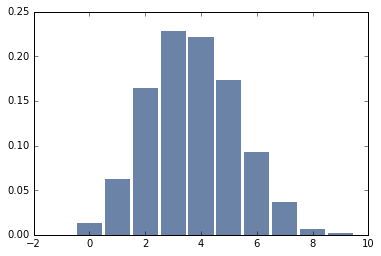

In [11]:
pmf = Pmf(ks)
thinkplot.Hist(pmf)
len(ks), np.mean(ks)

The mean should be near 3.7.  We can run this simulation more efficiently using NumPy.  First we generate a sample of `xs`:

In [12]:
xs = np.random.choice(a=[x1, x2], p=[0.3, 0.7], size=1000)
Hist(xs)

Hist({0.29999999999999999: 296, 0.40000000000000002: 704})

Then for each `x` we generate a `k`:

In [13]:
ks = np.random.binomial(n, xs)

And the results look similar.

3.6280000000000001

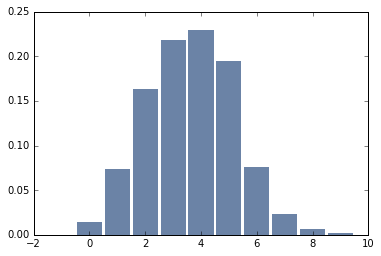

In [14]:
pmf = Pmf(ks)
thinkplot.Hist(pmf)
np.mean(ks)

One more way to do the same thing is to make a meta-Pmf, which contains the two binomial `Pmf` objects:

In [15]:
from thinkbayes2 import MakeBinomialPmf

pmf1 = MakeBinomialPmf(n, x1)
pmf2 = MakeBinomialPmf(n, x2)

metapmf = Pmf({pmf1:0.3, pmf2:0.7})
metapmf.Print()

Pmf({0: 0.028247524900000005, 1: 0.12106082100000018, 2: 0.23347444049999999, 3: 0.26682793200000016, 4: 0.20012094900000013, 5: 0.10291934520000007, 6: 0.03675690899999999, 7: 0.0090016920000000021, 8: 0.0014467004999999982, 9: 0.00013778100000000015, 10: 5.9048999999999949e-06}) 0.3
Pmf({0: 0.0060466176, 1: 0.040310784000000037, 2: 0.12093235199999994, 3: 0.21499084800000012, 4: 0.2508226560000002, 5: 0.20065812480000034, 6: 0.11147673600000013, 7: 0.04246732800000004, 8: 0.010616832, 9: 0.0015728640000000028, 10: 0.00010485760000000014}) 0.7


Here's how we can draw samples from the meta-Pmf:

In [16]:
ks = [metapmf.Random().Random() for _ in range(1000)]

And here are the results, one more time:

3.7309999999999999

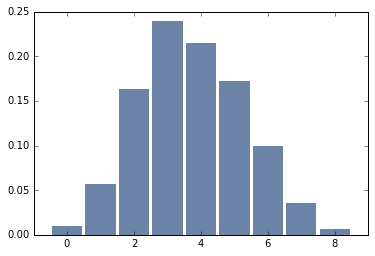

In [17]:
pmf = Pmf(ks)
thinkplot.Hist(pmf)
np.mean(ks)

This result, which we have estimated three ways, is a predictive distribution, based on our uncertainty about `x`.

We can compute the mixture analtically using `thinkbayes2.MakeMixture`:


    def MakeMixture(metapmf, label='mix'):
        """Make a mixture distribution.

        Args:
          metapmf: Pmf that maps from Pmfs to probs.
          label: string label for the new Pmf.

        Returns: Pmf object.
        """
        mix = Pmf(label=label)
        for pmf, p1 in metapmf.Items():
            for k, p2 in pmf.Items():
                mix[k] += p1 * p2
        return mix
        
The outer loop iterates through the Pmfs; the inner loop iterates through the items.

So `p1` is the probability of choosing a particular Pmf; `p2` is the probability of choosing a value from the Pmf.

In the example, each Pmf is associated with a value of `x` (probability of hitting a target).  The inner loop enumerates the values of `k` (number of targets hit after 10 shots).

3.7000000000000028

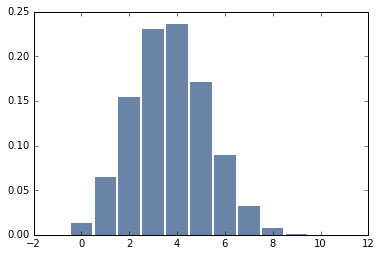

In [18]:
from thinkbayes2 import MakeMixture

mix = MakeMixture(metapmf)
thinkplot.Hist(mix)
mix.Mean()

**Exercise**: Assuming again that the distribution of `x` in the population of designs is well-modeled by a beta distribution with parameters α=2 and β=3, what the distribution if `k` if I choose a random Alien Blaster and fire 10 shots?